# Derin Öğrenme ile Gayrimenkul Kira Ücretlerinin Tahmin Edilmesi

Projede hepsiemlak.com sitesinde yer alan kiralık gayrimenkul ilanlarının kazınmasıyla oluşturulan verilerden yararlanılmıştır. Bu işlem 4 Büyükşehir için yapılmıştır ve veri ön işleme adımları gerçekleştirilip, hiper parametreleri optimize edilmiş derin öğrenme modeli ile kira ücretleri tahmin edilmiştir.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import sklearn.metrics as mt
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Veri kazıma ve veri tiplerinin düzenlenmesi işlemleri:

In [ ]:
tip=[]
oda=[]
buyukluk=[]
bina_yasi=[]
kat=[]
il=[]
semt=[]
fiyat=[]

buyuk_sehirler=["bursa","istanbul","izmir","ankara"]

for sehir in buyuk_sehirler:
    url1="https://www.hepsiemlak.com/{}-kiralik?page=1".format(sehir)
    parser1=BeautifulSoup(requests.get(url1).content, "html.parser")
    veri1=int(parser1.find("ul",{"class":"he-pagination__links"}).find_all("li",{"class":"he-pagination__item"})[-1].find("a").text)
    for sayfa in range(1,veri1+1):
        url="https://www.hepsiemlak.com/{}-kiralik?page={}".format(sehir,sayfa)
        parser=BeautifulSoup(requests.get(url).content, "html.parser")
        veri=parser.find("ul",{"class":"list-items-container"}).find_all("li",{"class":"listing-item"})
        for i in range(len(veri)):
            #ad.append(veri[i].find("div",{"class":"card-bottom-cage"}).find("h3").text.strip())
            tip.append(veri[i].find("div",{"class":"left"}).find_all("span")[1].text.strip())
            oda.append(veri[i].find("span",{"class":"celly houseRoomCount"}).find("span").text)
            buyukluk.append(veri[i].find("span",{"class":"celly squareMeter list-view-size"}).find("span").text.strip().split()[0])
            bina_yasi.append(veri[i].find("span",{"class":"celly buildingAge"}).find("span").text.strip())
            kat.append(veri[i].find("span",{"class":"celly floortype"}).text.strip())
            il.append(sehir.capitalize())
            semt.append(veri[i].find("div",{"class":"list-view-location"}).find("span").text.strip())
            fiyat.append(veri[i].find("div",{"class":"top"}).find("span",{"class":"list-view-price"}).text.split()[0])

data=pd.DataFrame({"ev_tipi":tip,"oda_sayisi":oda,"buyukluk":buyukluk,"bina_yasi":bina_yasi,
                  "kat":kat,"il":il,"semt":semt,"fiyat":fiyat})

semt2=[]
fiyat2=[]
buyukluk2=[]
for i in range(len(data)):
    duzenle=str(data["semt"][i]).replace(",","")
    duzenle2=str(data["fiyat"][i]).replace(".","")
    duzenle3=str(data["buyukluk"][i]).replace(".","")
    semt2.append(duzenle)
    fiyat2.append(duzenle2)
    buyukluk2.append(duzenle3)

data["semt"]=semt2
data["fiyat"]=fiyat2
data["buyukluk"]=buyukluk2

data["bina_yasi"]=["0" if kod=="Sıfır Bina" else kod for kod in data["bina_yasi"]]

data["buyukluk"]=data["buyukluk"].astype(float)
data["bina_yasi"]=data["bina_yasi"].astype(float)
data["fiyat"]=data["fiyat"].astype(float)

In [ ]:
dosya=data.to_csv("C:/Users/okand/Desktop/projeler2/Kira_tahmini/kira_dataset.csv",index=False)

In [2]:
veri=pd.read_csv("/content/kira_dataset.csv")
veri.head()

,ev_tipi,oda_sayisi,buyukluk,bina_yasi,kat,il,semt,fiyat
0,Daire,2 + 1,110.0,2.0,12. Kat,Bursa,Nilüfer,17500.0
1,Daire,3 + 1,145.0,15.0,3. Kat,Bursa,Nilüfer,11000.0
2,Daire,3 + 1,140.0,25.0,2. Kat,Bursa,Nilüfer,9000.0
3,Daire,3 + 1,150.0,20.0,4. Kat,Bursa,Gemlik,20000.0
4,Daire,3 + 1,160.0,5.0,2. Kat,Bursa,Osmangazi,8000.0


In [3]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18310 entries, 0 to 18309
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ev_tipi     18310 non-null  object 
 1   oda_sayisi  18310 non-null  object 
 2   buyukluk    18310 non-null  float64
 3   bina_yasi   18310 non-null  float64
 4   kat         16898 non-null  object 
 5   il          18310 non-null  object 
 6   semt        18310 non-null  object 
 7   fiyat       18310 non-null  float64
dtypes: float64(3), object(5)
memory usage: 1.1+ MB


In [4]:
veri.isnull().sum()/len(veri)

ev_tipi       0.000000
oda_sayisi    0.000000
buyukluk      0.000000
bina_yasi     0.000000
kat           0.077116
il            0.000000
semt          0.000000
fiyat         0.000000
dtype: float64

In [5]:
veri["kat"].unique()

array(['12. Kat', '3. Kat', '2. Kat', '4. Kat', 'Asma Kat', 'Giriş Katı',
       'En Üst Kat', 'Bahçe Katı', '5. Kat', 'Ara Kat', '1. Kat',
       '7. Kat', 'Yüksek Giriş', '6. Kat', '10. Kat', 'Kot 3', nan,
       '9. Kat', 'Teras Katı', 'Zemin', '17. Kat', 'Kot 1', 'Çatı Katı',
       '8. Kat', '11. Kat', '14. Kat', '19. Kat', '20. Kat', '15. Kat',
       '21 ve üzeri', '18. Kat', 'Bodrum', '13. Kat', 'Villa Katı',
       'Kot 2', 'Bodrum ve Zemin', 'Yarı Bodrum', '16. Kat', 'Tripleks'],
      dtype=object)

Sadece kat özelliğinde boş değerler mevcut. Bu boş değerler villa, çiftlik evi, yalı gibi müstakil evlerin gözlemlerinde yer almaktadır. Bu boş değerleri mustakil olarak doldurdum.

In [6]:
nan_indeksler=[]
for i in range(len(veri)):
  if str(veri["kat"][i])=="nan":
    nan_indeksler.append(i)
  
print(veri.loc[nan_indeksler]["ev_tipi"].unique())

veri.loc[nan_indeksler,"kat"]="Mustakil"

print(veri.isnull().sum()/len(veri))



['Villa' 'Müstakil Ev' 'Bina' 'Çiftlik Evi' 'Köşk' 'Yalı' 'Köy Evi']
ev_tipi       0.0
oda_sayisi    0.0
buyukluk      0.0
bina_yasi     0.0
kat           0.0
il            0.0
semt          0.0
fiyat         0.0
dtype: float64


## Keşifçi Veri Analizi

<ipython-input-7-74f3e329e2f3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  veri_corr=veri.corr()


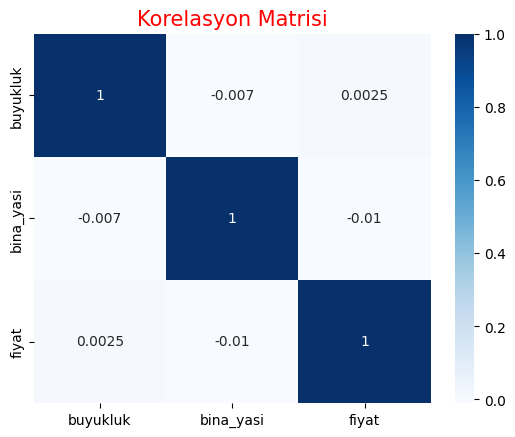

In [7]:
veri_corr=veri.corr()
plt.title("Korelasyon Matrisi", color="red", fontsize=15)
sns.heatmap(veri_corr,annot=True,cmap="Blues")
sns.set(font_scale=2,style='white')
plt.show()

İllere ve ev tiplerine göre kira ortalamaları:

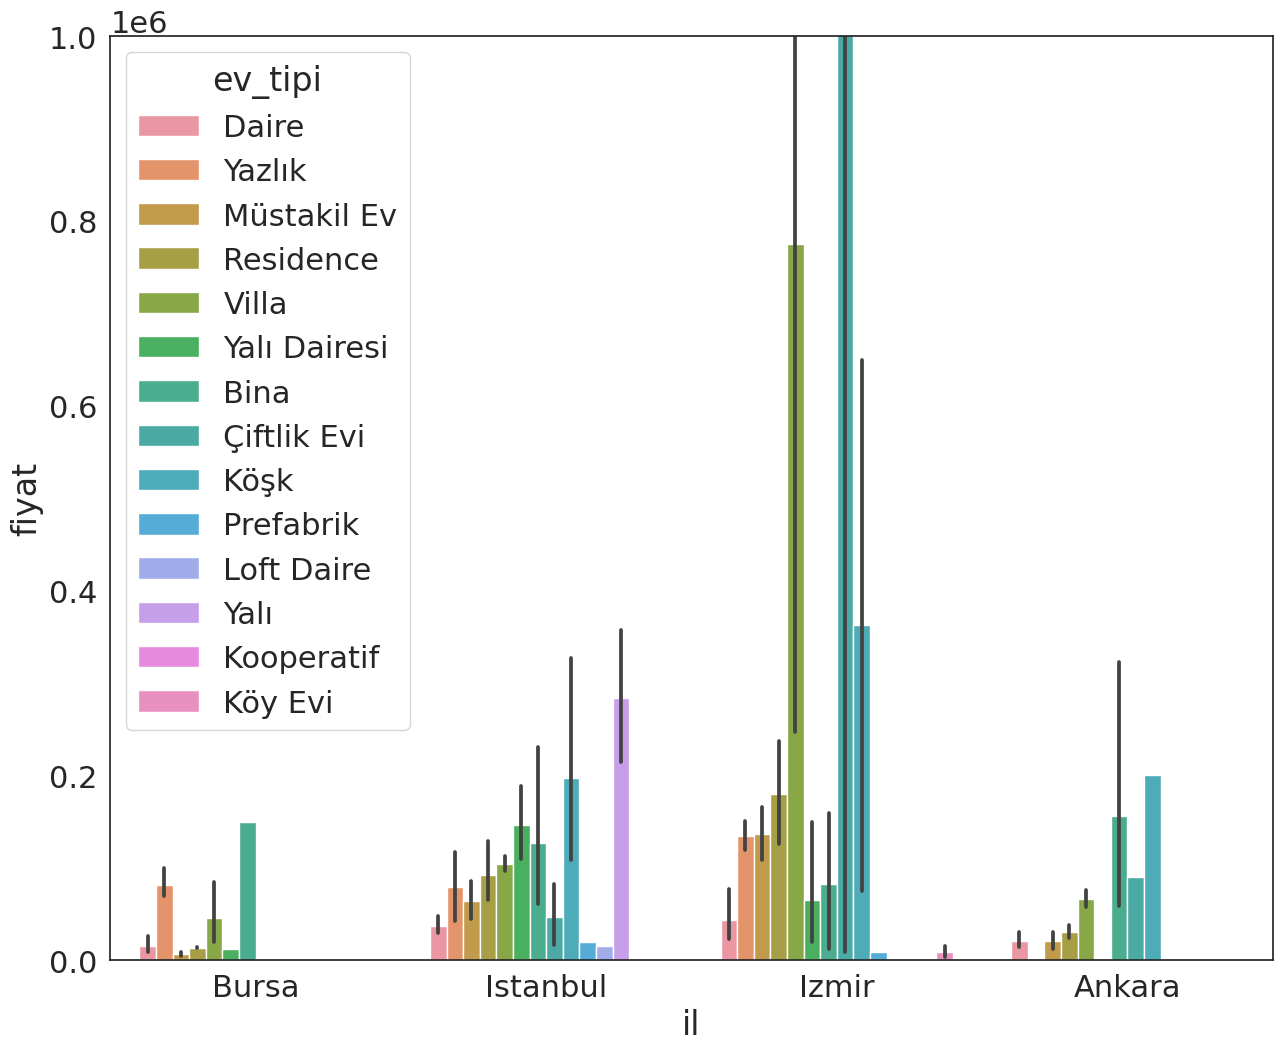

In [8]:
plt.figure(figsize=(15,12))
sns.barplot(data=veri,x="il",y="fiyat",hue="ev_tipi")
plt.ylim([0,1000000])
plt.show()

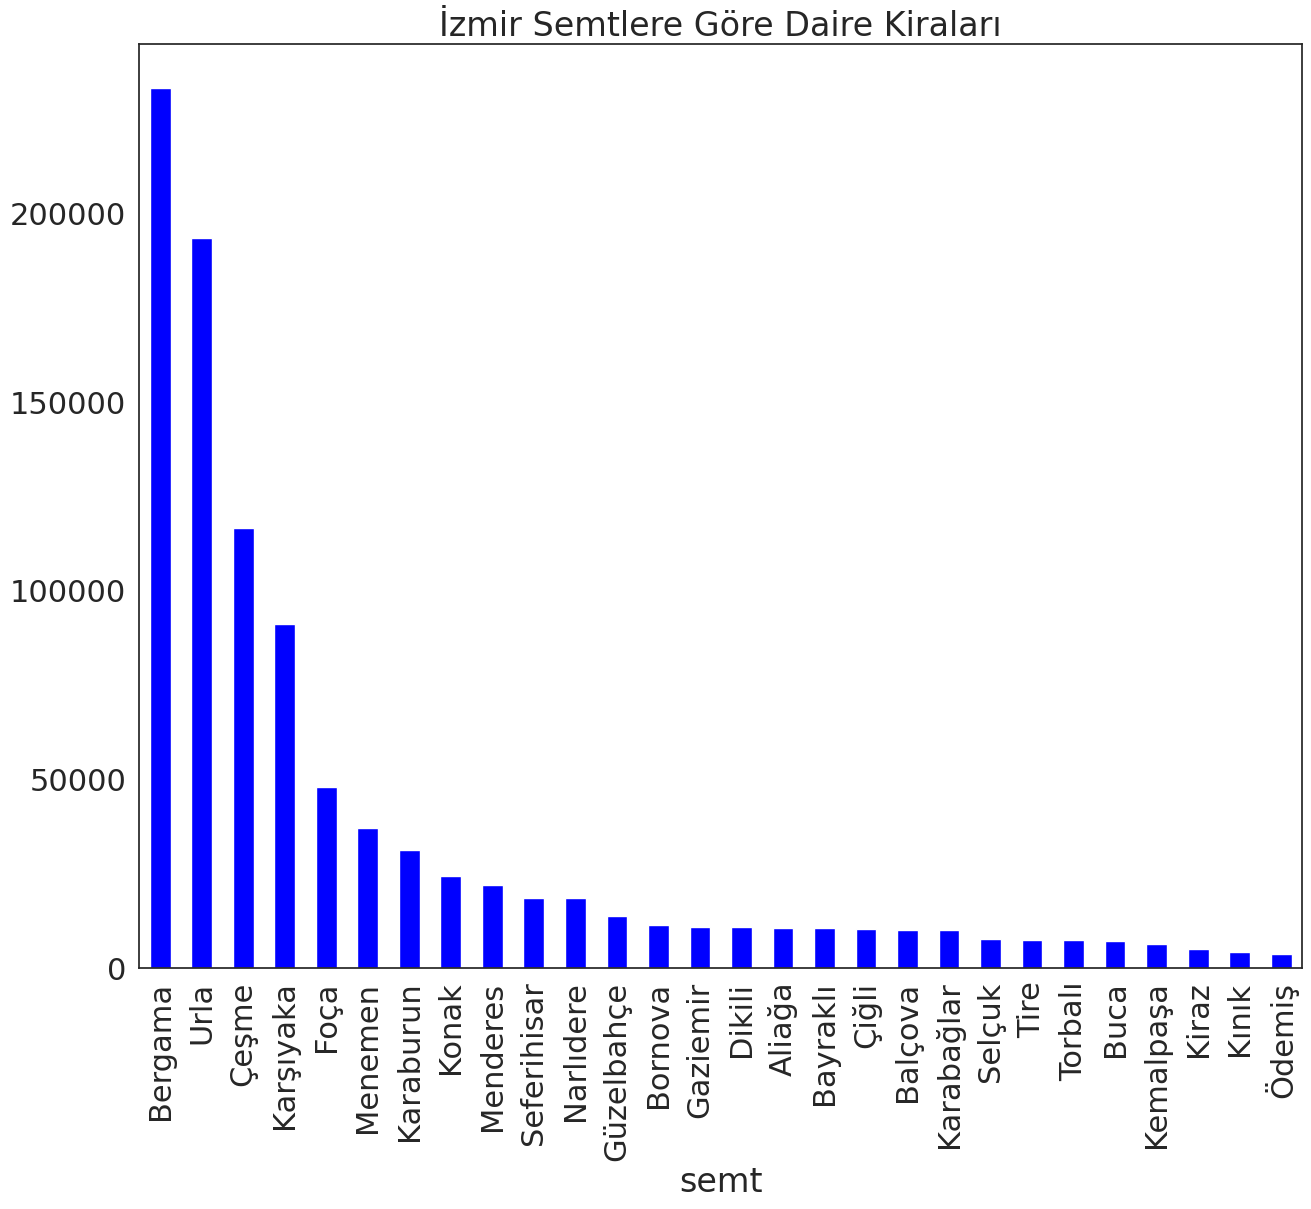

In [9]:
fig=plt.figure(figsize=(15,12))
veri[(veri["il"]=="Izmir") & (veri["ev_tipi"]=="Daire")].groupby("semt")["fiyat"].mean().sort_values(ascending=False).plot(kind='bar', color='blue',label="Semtlere göre daire kiraları")
plt.title("İzmir Semtlere Göre Daire Kiraları")
plt.show()

In [10]:
veri[(veri["il"]=="Izmir") & (veri["ev_tipi"]=="Daire")].groupby("semt")["fiyat"].mean().sort_values(ascending=False)

semt
Bergama        233142.857143
Urla           193415.358974
Çeşme          116515.609929
Karşıyaka       91294.171779
Foça            48068.292683
Menemen         37012.500000
Karaburun       31250.000000
Konak           24480.284553
Menderes        21984.375000
Seferihisar     18690.476190
Narlıdere       18595.238095
Güzelbahçe      13884.615385
Bornova         11485.855263
Gaziemir        10846.666667
Dikili          10835.000000
Aliağa          10722.222222
Bayraklı        10562.962963
Çiğli           10297.058824
Balçova         10137.113636
Karabağlar       9970.454545
Selçuk           7666.666667
Tire             7500.000000
Torbalı          7420.000000
Buca             7127.391304
Kemalpaşa        6406.250000
Kiraz            5166.666667
Kınık            4166.666667
Ödemiş           3850.000000
Name: fiyat, dtype: float64

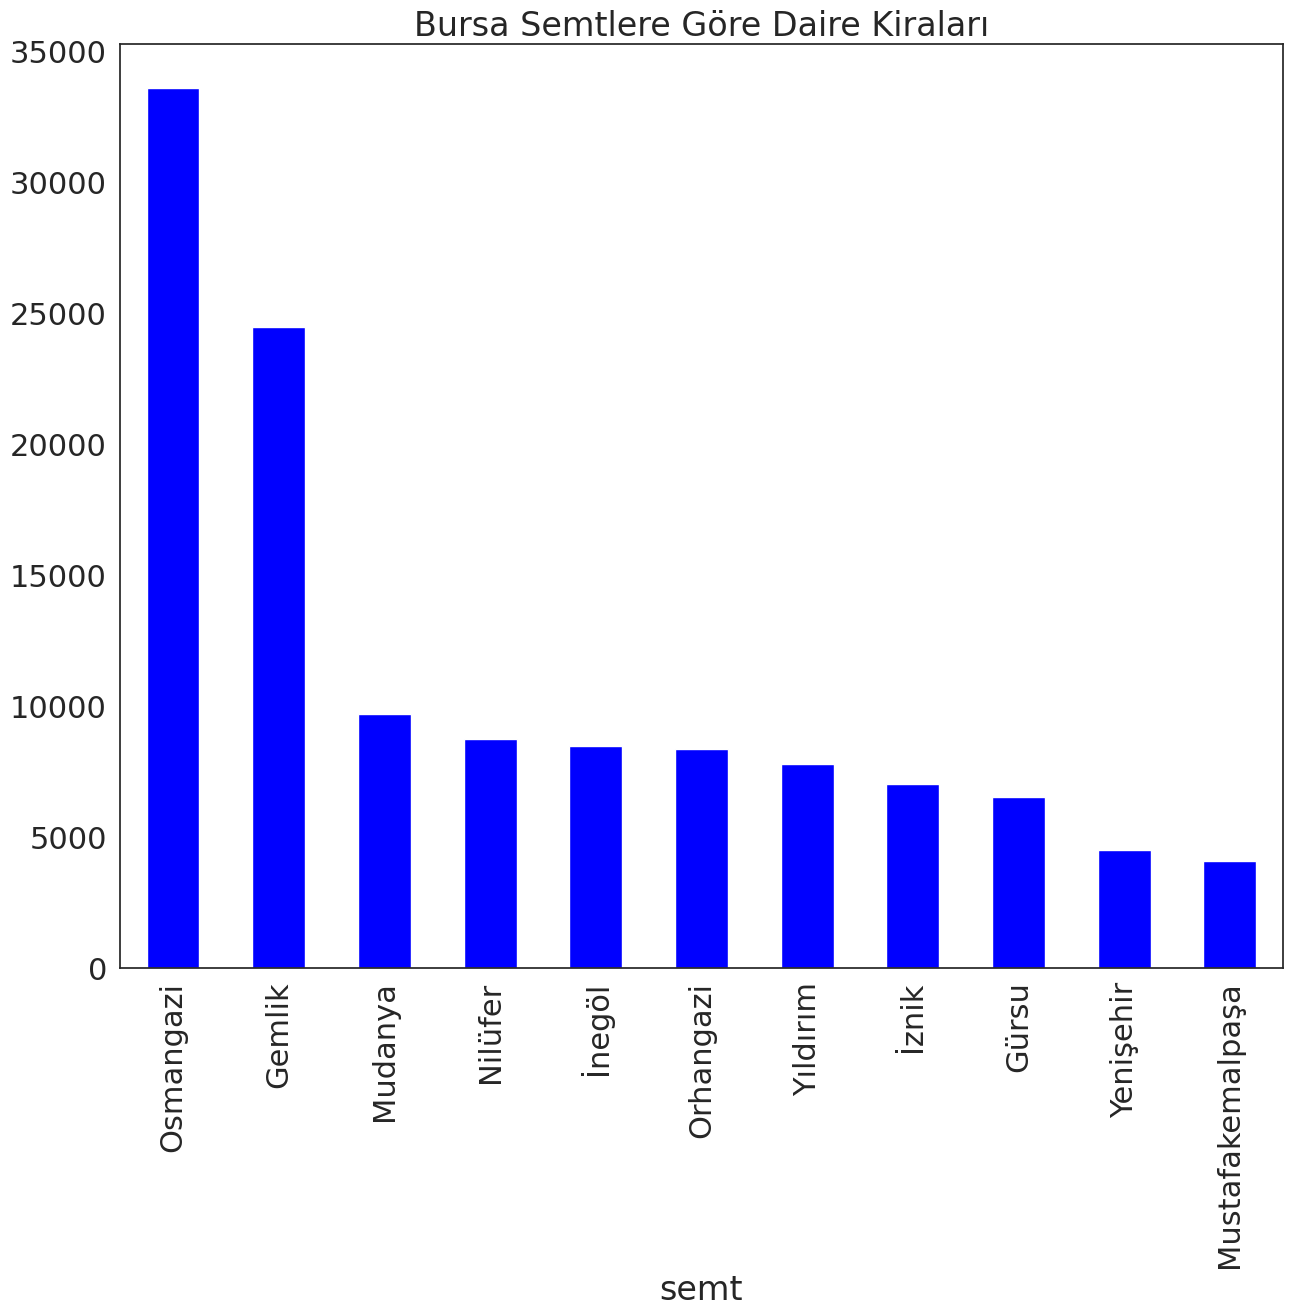

In [11]:
fig=plt.figure(figsize=(15,12))
veri[(veri["il"]=="Bursa") & (veri["ev_tipi"]=="Daire")].groupby("semt")["fiyat"].mean().sort_values(ascending=False).plot(kind='bar', color='blue',label="Semtlere göre daire kiraları")
plt.title("Bursa Semtlere Göre Daire Kiraları")
plt.show()

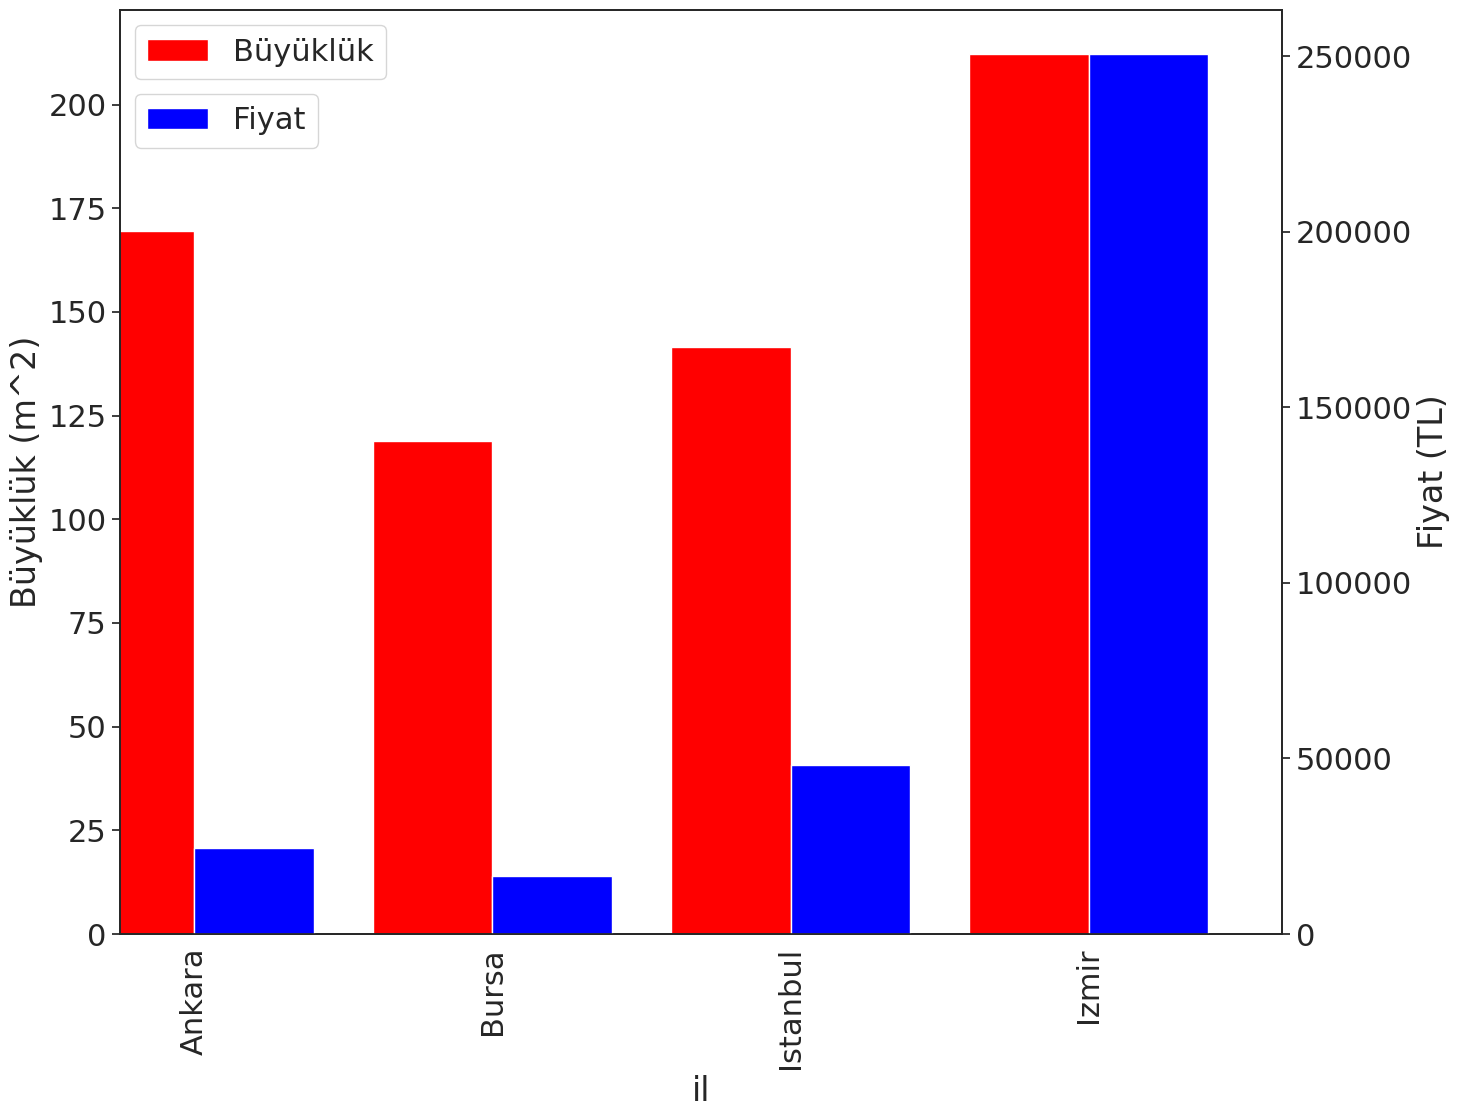

In [12]:
fig=plt.figure(figsize=(15,12))
ax=fig.add_subplot()
ax2=ax.twinx()
width = 0.4

veri.groupby("il")["buyukluk"].mean().plot(kind='bar', color='red', ax=ax, width=width, position=1,label="Büyüklük")
veri.groupby("il")["fiyat"].mean().plot(kind='bar', color='blue', ax=ax2, width=width, position=0,label="Fiyat")

ax.set_ylabel('Büyüklük (m^2)')
ax2.set_ylabel('Fiyat (TL)')
ax.legend()
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.88))

plt.show()

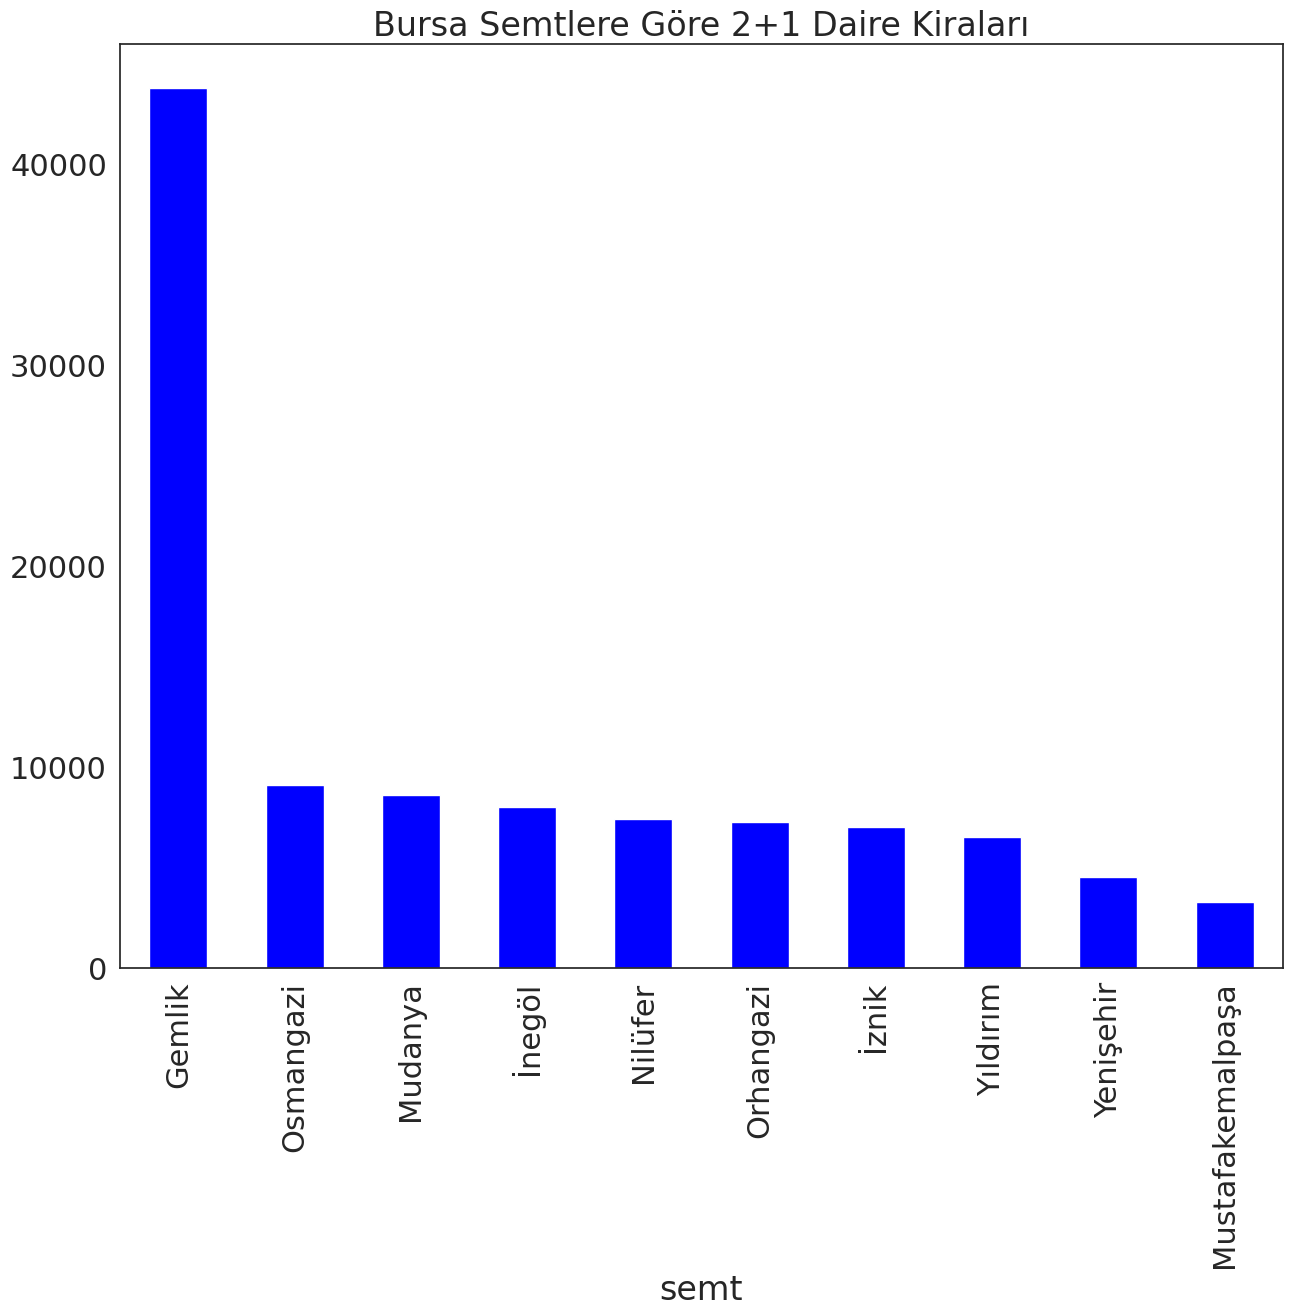

In [13]:
fig=plt.figure(figsize=(15,12))
veri[(veri["il"]=="Bursa") & (veri["ev_tipi"]=="Daire") & (veri["oda_sayisi"]=="2 + 1")].groupby("semt")["fiyat"].mean().sort_values(ascending=False).plot(kind='bar', color='blue',label="Semtlere göre 2+1 daire kiraları")
plt.title("Bursa Semtlere Göre 2+1 Daire Kiraları")
plt.show()

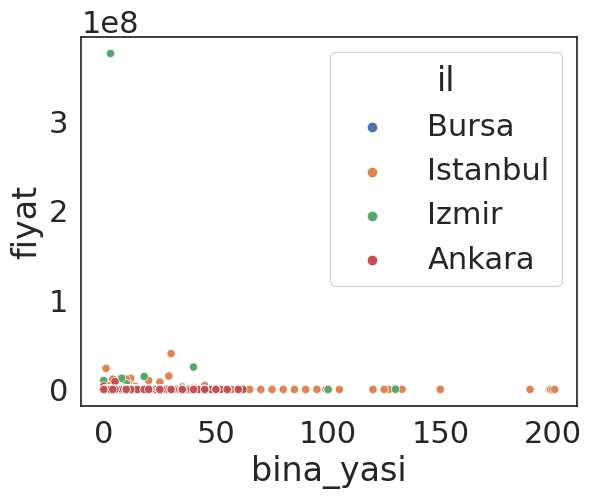

In [14]:
sns.scatterplot(x = "bina_yasi", y = "fiyat", hue = "il",data = veri);

## Aykırı Değer Analizi

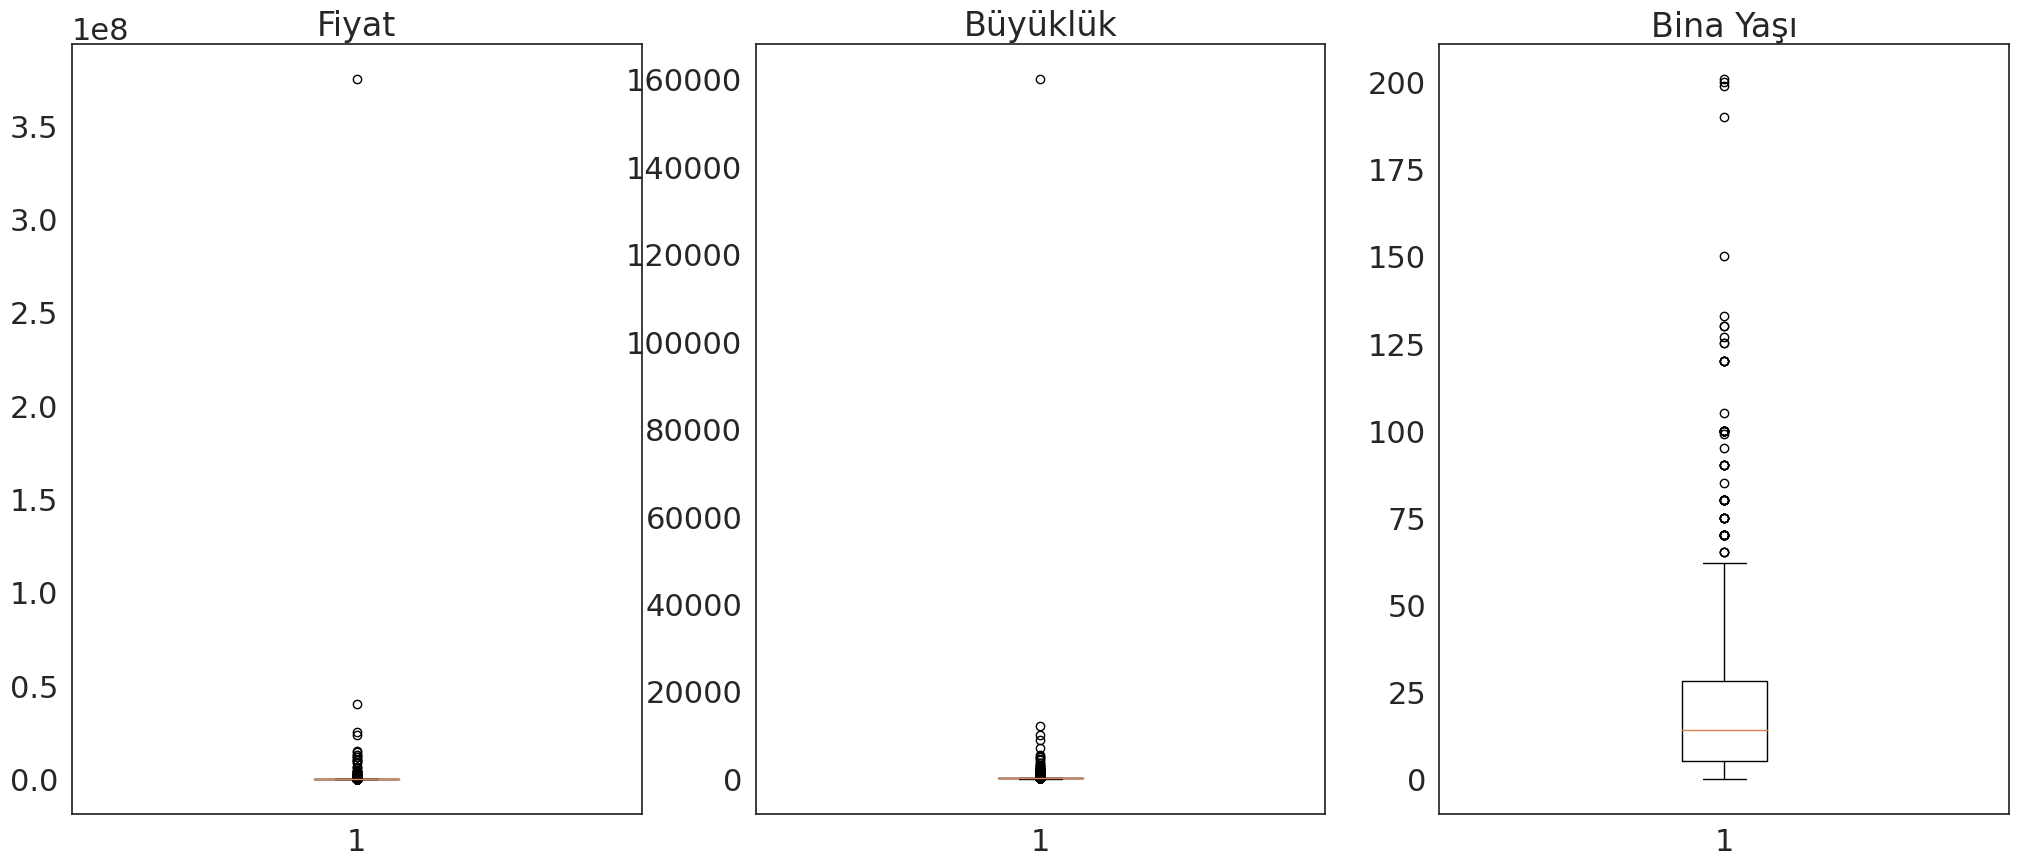

In [15]:
fig,ax=plt.subplots(1,3,figsize=(25,10))
ax[0].boxplot(veri["fiyat"])
ax[0].set_title("Fiyat")
ax[1].boxplot(veri["buyukluk"])
ax[1].set_title("Büyüklük")
ax[2].boxplot(veri["bina_yasi"])
ax[2].set_title("Bina Yaşı")
plt.show()

In [16]:
# Çok değişkenli aykırı değer analizi Local Outlier Factor:

veri_n=veri.select_dtypes(include=['float64', 'int64'])
clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
clf.fit_predict(veri_n)
df_skor = clf.negative_outlier_factor_
print(np.sort(df_skor)[0:100])
print(np.median(np.sort(df_skor)))
print(np.sort(df_skor).mean())
print(np.quantile(np.sort(df_skor),0.75))
print(np.quantile(np.sort(df_skor),0.25))

[-749.81714614 -565.19320312 -477.08213204 -449.21604046 -392.11967857
 -392.11967857 -380.18852522 -340.79472434 -310.01530467 -288.58751363
 -284.07199835 -284.06879549 -284.05925171 -284.05893214 -276.87899515
 -274.37470459 -270.60784709 -270.6078431  -270.25021258 -263.27579921
 -261.78376761 -257.53994994 -256.0058401  -218.60501074 -214.36318097
 -201.03002175 -201.03002175 -196.71540193 -194.9938662  -185.95840512
 -178.13502376 -165.5634306  -164.38037577 -162.85293496 -162.02719115
 -161.5973166  -161.13915199 -160.78852931 -155.7884641  -155.37149876
 -149.77369971 -143.72684873 -137.48881798 -130.30174782 -130.30174679
 -130.30097579 -130.29817274 -126.91277004 -126.47795329 -124.9415224
 -120.38129127 -120.38015351 -119.86601243 -119.09207056 -118.62135716
 -118.48855294 -115.40792351 -113.14921059 -109.40583883 -107.28347092
  -99.78995636  -94.96413554  -91.53130415  -90.85104867  -89.84854823
  -88.46329531  -85.57358567  -85.46128443  -85.46128435  -81.42890736
  -79.2

In [17]:
sonuc=np.sort(df_skor)
sonuc[-13733:]

array([-1.16219577, -1.16217122, -1.1621001 , ..., -0.91172636,
       -0.91172636, -0.91026136])

In [18]:
sonuc[-13733] # aykırı değer sınırı olarak 0.25 in kartili belirleyeceğiz

-1.1621957746959706

In [19]:
esik_deger=sonuc[-13733]
aykiri_tf=df_skor>esik_deger

Aykırı değerleri silelim:

In [20]:
# silme:

veri2=veri[df_skor > esik_deger]

In [21]:
veri2=veri2.reset_index()
veri2=veri2.drop(columns="index")
veri2.head()

,ev_tipi,oda_sayisi,buyukluk,bina_yasi,kat,il,semt,fiyat
0,Daire,2 + 1,110.0,2.0,12. Kat,Bursa,Nilüfer,17500.0
1,Daire,3 + 1,145.0,15.0,3. Kat,Bursa,Nilüfer,11000.0
2,Daire,3 + 1,140.0,25.0,2. Kat,Bursa,Nilüfer,9000.0
3,Daire,3 + 1,150.0,20.0,4. Kat,Bursa,Gemlik,20000.0
4,Yazlık,2 + 1,110.0,40.0,Asma Kat,Bursa,Mudanya,100000.0


In [22]:
veri2.shape

(13732, 8)

## Derin Öğrenme

In [23]:
cat=[]
sur_deg=[]

for i in veri2.columns:
  if veri2[i].dtypes=="object":
    cat.append(i)
  elif veri2[i].dtypes=="float":
    sur_deg.append(i)

print(cat)
print(sur_deg)


['ev_tipi', 'oda_sayisi', 'kat', 'il', 'semt']
['buyukluk', 'bina_yasi', 'fiyat']


In [24]:
# encodiring:
le=LabelEncoder()

for i in cat:
  veri2[i]=le.fit_transform(veri2[i])

veri2.head()

,ev_tipi,oda_sayisi,buyukluk,bina_yasi,kat,il,semt,fiyat
0,1,8,110.0,2.0,3,1,59,17500.0
1,1,19,145.0,15.0,14,1,59,11000.0
2,1,19,140.0,25.0,11,1,59,9000.0
3,1,19,150.0,20.0,15,1,33,20000.0
4,12,8,110.0,40.0,22,1,56,100000.0


In [25]:
y=veri2["fiyat"]
X=veri2.drop(columns="fiyat")

# Standartlaştırma:
sc=StandardScaler()
X=sc.fit_transform(X)

# Eğitim Test verisi ayırma:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=0)

<ipython-input-36-fd63fc32e8b5>:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regres=KerasRegressor(build_fn=model_kur,verbose=0)


86/86 [==============================] - 0s 1ms/step


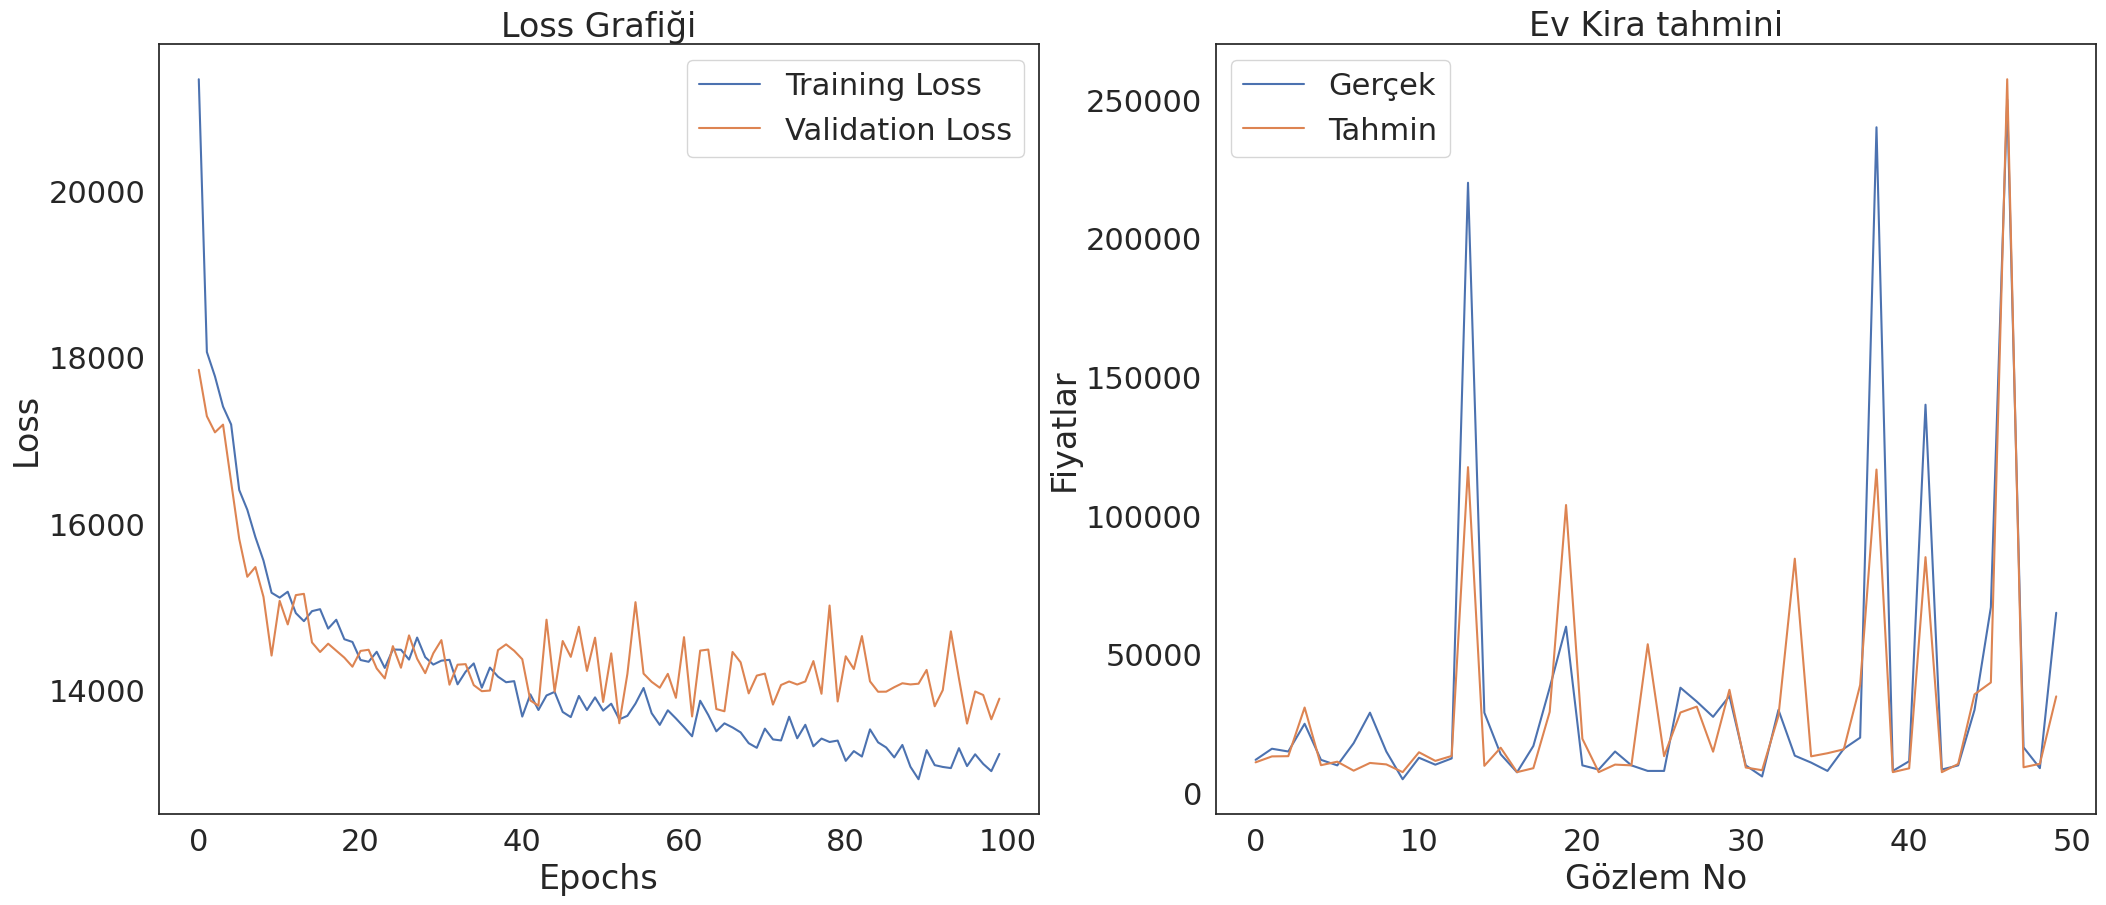

In [36]:

def model_kur(units=64,activation="linear",learning_rate=0.01,hidden_layers=2,dropout_rate=0.2,patience=5):
  model=Sequential()
  model.add(Dense(units=units,input_dim=X_train.shape[1],activation=activation))
  for i in range(hidden_layers):
    model.add(Dense(units=units,activation=activation))
    model.add(Dropout(dropout_rate))

  model.add(Dense(1,activation=activation))
  model.compile(optimizer=Adam(learning_rate),loss="mae",metrics=["mae"])
  return model

parametreler={
    "units":[32,64],
    "activation":["linear","relu"],
    "hidden_layers":[2,3,4],
    "dropout_rate":[0.0,0.1,0.2],
    "epochs":[50,100],
    "learning_rate":[0.001,0.01],
    "batch_size":[32,64,96]
}

regres=KerasRegressor(build_fn=model_kur,verbose=0)
grid=GridSearchCV(estimator=regres,param_grid=parametreler,cv=3)
gridsonuc=grid.fit(X_train,y_train)
bestparam=gridsonuc.best_params_

bestmodel=model_kur(units=bestparam["units"],activation=bestparam["activation"],learning_rate=bestparam["learning_rate"],hidden_layers=bestparam["hidden_layers"],
                    dropout_rate=bestparam["dropout_rate"])

cıktı=bestmodel.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=bestparam["epochs"],batch_size=bestparam["batch_size"],verbose=0)

tahmin=bestmodel.predict(X_test)

fig,ax=plt.subplots(1,2,figsize=(25,10))
ax[0].plot(cıktı.history["loss"],label="Training Loss")
ax[0].plot(cıktı.history["val_loss"],label="Validation Loss")
ax[0].set_title("Loss Grafiği")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend()
ax[1].plot(range(len(y_test[:50])),y_test[:50],label="Gerçek")
ax[1].plot(range(len(y_test[:50])),tahmin[:50],label="Tahmin")
ax[1].set_title("Ev Kira tahmini")
ax[1].set_ylabel("Fiyatlar")
ax[1].set_xlabel("Gözlem No")
ax[1].legend()
plt.show()


Hiperparametreleri optimize edilmiş model sonucunda Loss grafiğine baktığımızda val_loss'ların yükseliş eğilimine geçmesi overfitting sorununun olduğunu göstermektedir. Early stopping yardımı ile bu sorunun üstesinden gelmeye çalışalım:

In [39]:
bestparam

{'activation': 'relu',
 'batch_size': 96,
 'dropout_rate': 0.1,
 'epochs': 100,
 'hidden_layers': 4,
 'learning_rate': 0.01,
 'units': 64}

86/86 [==============================] - 0s 1ms/step


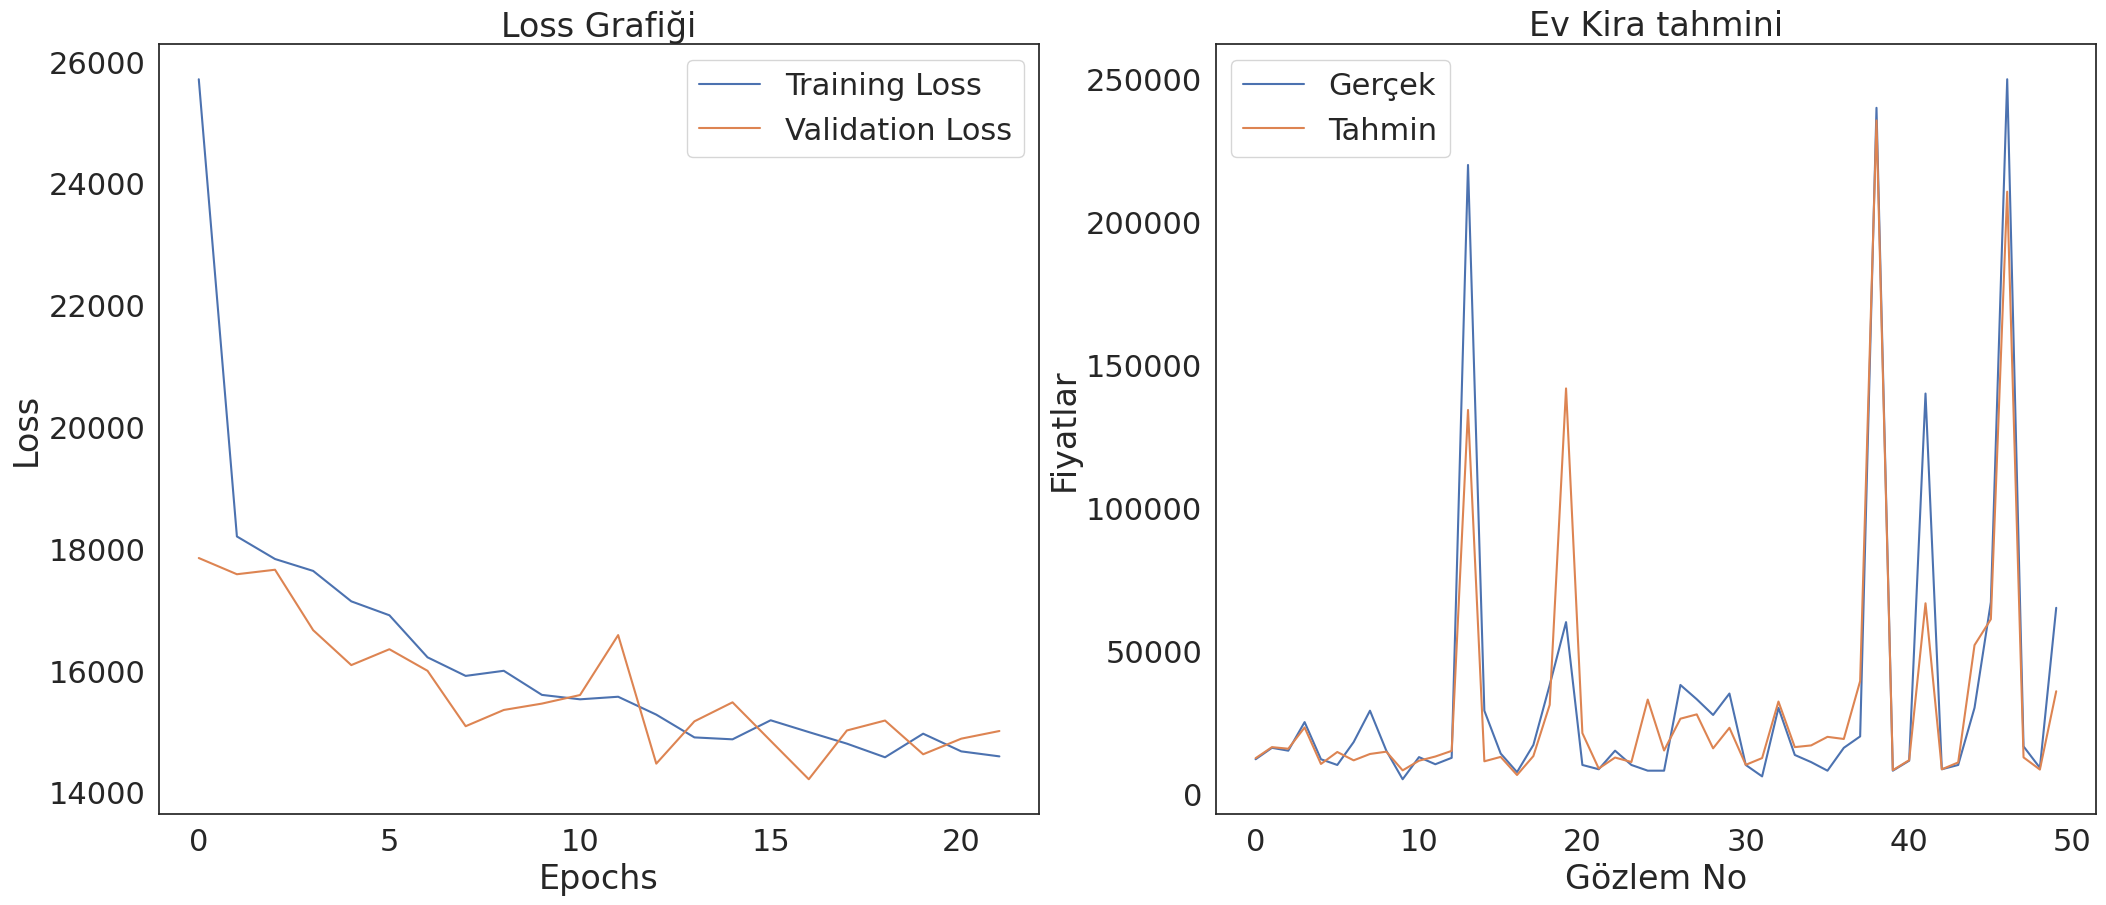

In [49]:
def model_kur(units=64,activation="relu",learning_rate=0.01,hidden_layers=4,dropout_rate=0.1):
  model=Sequential()
  model.add(Dense(units=units,input_dim=X_train.shape[1],activation=activation))
  for i in range(hidden_layers):
    model.add(Dense(units=units,activation=activation))
    model.add(Dropout(dropout_rate))

  model.add(Dense(1,activation=activation))
  model.compile(optimizer=Adam(learning_rate),loss="mae",metrics=["mae"])
  es=EarlyStopping(monitor="val_loss",patience=5,mode="min",verbose=0)
  return model,es

bestmodel2=model_kur()[0]
cıktı2=bestmodel2.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100,batch_size=96,verbose=0,callbacks=[model_kur()[1]])

tahmin2=bestmodel2.predict(X_test)

fig,ax=plt.subplots(1,2,figsize=(25,10))
ax[0].plot(cıktı2.history["loss"],label="Training Loss")
ax[0].plot(cıktı2.history["val_loss"],label="Validation Loss")
ax[0].set_title("Loss Grafiği")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend()
ax[1].plot(range(len(y_test[:50])),y_test[:50],label="Gerçek")
ax[1].plot(range(len(y_test[:50])),tahmin2[:50],label="Tahmin")
ax[1].set_title("Ev Kira tahmini")
ax[1].set_ylabel("Fiyatlar")
ax[1].set_xlabel("Gözlem No")
ax[1].legend()
plt.show()

Early stopiimg uygulandıktan sonra modelin son hali yukarıdadır. Sürekli değişkenler arasında ilişkinin olmaması iyi bir tahmin modelinin ortaya çıkamayacağına yönelik önsezi vermişti. Değişken çeşitliliği sağlanıp daha iyi tahmin çalışmaları yapılabilir.